<a href="https://colab.research.google.com/github/Ram124403/Ram/blob/main/Water_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Columns in dataset: [' Date ', '074-01 : \nLongridge : \nNetflow Stored \n(l/s)', '074-03 : \nPreston Road, \nLongridge : \nNetflow Stored \nMinus Cont \nLogged (l/s)', '074-04 : \nWhittingham \nRoad : Netflow \nStored (l/s)', '074-11 : \nRibchester \nVillage : \nNetflow Stored \nMinus Cont \nLogged (l/s)', '074-02 : Tan \nYard Lane : \nNetflow Stored \n(l/s)', '[Continuous] \nMeter : \n207330265 : MR \nCOULSTON T/A \nRIBBLE FARM \nFAYRE : Flow \nWith Edits \n(l/s)', '[Continuous] \nMeter : 6924916 \n: NO CUSTOMER : \nFlow With Edits \n(l/s)', '[Continuous] \nMeter : 5680357 \n: F TALBOT & CO \n: Flow With \nEdits (l/s)']
✅ Using target column: 074-01 : 
Longridge : 
Netflow Stored 
(l/s)


/tmp/ipython-input-218153652.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_cols[0]] = pd.to_datetime(df[date_cols[0]], infer_datetime_format=True, dayfirst=True, errors="raise")


MAE: 1.596450803407695
R2 Score: 0.8075382874748943


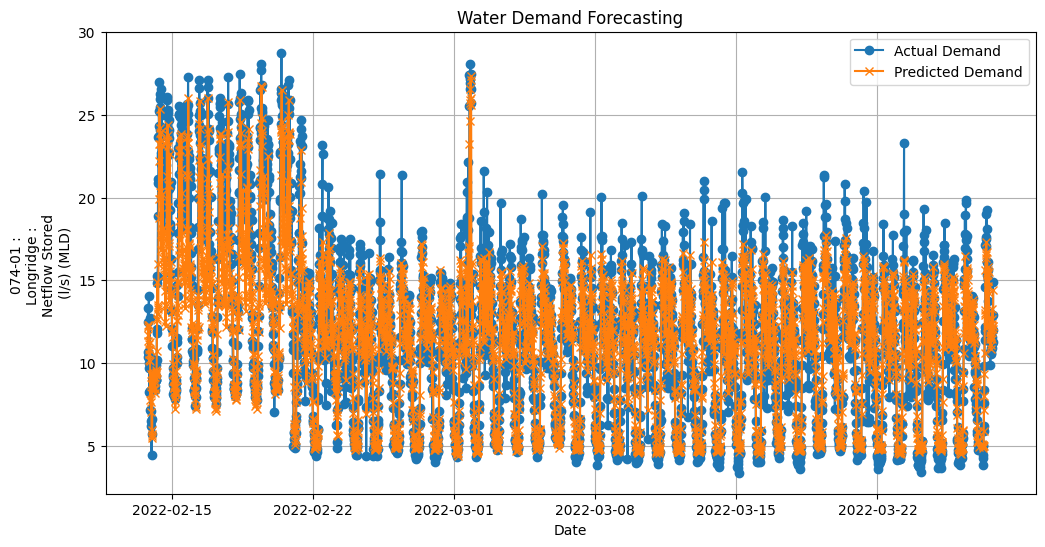

In [5]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


file_path = "/content/drive/MyDrive/netbase_inlet-outlet-cont_logged_user_April2018.csv"
df = pd.read_csv(file_path)

print("Columns in dataset:", df.columns.tolist())

date_cols = [c for c in df.columns if "date" in c.lower() or "day" in c.lower()]

if date_cols:
    try:

        df[date_cols[0]] = pd.to_datetime(df[date_cols[0]], infer_datetime_format=True, dayfirst=True, errors="raise")
    except Exception:

        df[date_cols[0]] = pd.to_datetime(df[date_cols[0]], format="%d/%m/%Y %H:%M", errors="coerce")

    df = df.sort_values(date_cols[0])
    df.rename(columns={date_cols[0]: "date"}, inplace=True)
else:
    df["date"] = pd.date_range(start="2024-01-01", periods=len(df))

possible_targets = ["demand_mld", "flow", "outlet", "inlet", "usage", "consumption"]
target_col = None
for col in df.columns:
    if any(key in col.lower() for key in possible_targets):
        target_col = col
        break

if target_col is None:
    raise ValueError("Could not detect demand column! Please rename your demand/flow column to something like 'demand_mld', 'flow', 'usage'.")

print(f"✅ Using target column: {target_col}")


df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df["day_of_week"] = df["date"].dt.dayofweek


df["demand_lag1"] = df[target_col].shift(1)
df["demand_7d_avg"] = df[target_col].shift(1).rolling(7).mean()


df = df.dropna().reset_index(drop=True)


FEATURES = [col for col in df.columns if col not in ["date", target_col]]
TARGET = target_col

X = df[FEATURES]
y = df[TARGET]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


plt.figure(figsize=(12,6))
plt.plot(df["date"].iloc[-len(y_test):], y_test, label="Actual Demand", marker="o")
plt.plot(df["date"].iloc[-len(y_test):], y_pred, label="Predicted Demand", marker="x")
plt.title("Water Demand Forecasting")
plt.xlabel("Date")
plt.ylabel(f"{TARGET} (MLD)")
plt.legend()
plt.grid(True)
plt.show()